#### Purpose: We want daily snapshot images of a flood, so that e.g. a flood lasting for 100 days, gets 100 unique extent images, one for each day

**ASSUMPTIONS:**

* Assumption 1: the "duration" value in the Global Flood Database tiff images are all calculated from a common "day 1" corresponding to the start of the flood.

* Assumption 2: the flood extent layer in the tiff images from Global Flood Database already exclude permanent water co-ordinates, i.e. pixels are labelled as flood according to the basic idea that **flood pixel = pixel changed from not water to water**

* Assumption 3: duration data follow a simplified flood model whereby water levels rise to the maximum on the first day and then durations "per pixel" drop over time as the water subsides.


In [1]:
import pickle
import cv2
import skimage
from matplotlib import pyplot as plt
import numpy as np
from datetime import timedelta
import pandas as pd


gfd_root = "STEP 1 - Data Acquisition/Global Flood Database/"
gfd_tif_dir = "STEP 1 - Data Acquisition/Global Flood Database/TIF/unzipped/"
sentinel_root = "STEP 1  - Data Acquisition/Sentinel from Copernicus/"

Get the ID and start/end dates of the Indian floods according to the Global Flood Database

In [2]:
with open(gfd_root+'meta_tif_df.pkl', 'rb') as f:
    floods_df = pickle.load(f) 
f.close()

#cut down to 2018 only
floods_df = floods_df[floods_df.flood_year=='2018']

floods_df.head()

,DFO_id,tif_filename,flood_year,flood_start,flood_end
142,DFO_4632,DFO_4632_From_20180615_to_20180620.tif,2018,2018-06-15,2018-06-20
143,DFO_4640,DFO_4640_From_20180625_to_20180711.tif,2018,2018-06-25,2018-07-11
144,DFO_4645,DFO_4645_From_20180703_to_20180711.tif,2018,2018-07-03,2018-07-11
145,DFO_4665,DFO_4665_From_20180802_to_20180810.tif,2018,2018-08-02,2018-08-10
146,DFO_4673,DFO_4673_From_20180901_to_20180907.tif,2018,2018-09-01,2018-09-07


Choose a 5-day flood to develop the method

In [3]:
img_filename = gfd_tif_dir+'DFO_4632_From_20180615_to_20180620.tif'
img = skimage.io.imread(img_filename,plugin='tifffile')

Visualize the image layers as a sanity check (comment-lines show layer info from Global Flood Database documentation)

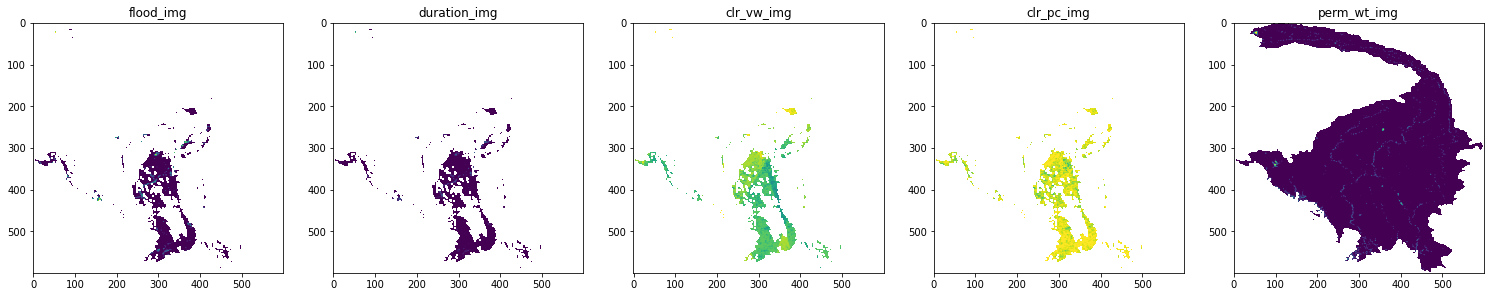

In [4]:
#Band 1: Name: "flooded", Min: 0, Max: 1. Maximum extent of flood water during an event.  
#• 1 – area of surface water 
#• 0 – no water 
flood_img = img[:,:,0]

#Band 2: Name: “flood_duration”, Units: days, Min: 0, Max: 65535. Duration of surface water during an event in days. 
# Pixel values indicate the number of composite days a pixel’s area was considered water during an event. 3-day MODIS composites were used. 
duration_img = img[:,:,1]

#Band 3: Name: “clear_views”, Units: days, Min: 0, Max: 65535. Number of cloud-free observations in days between the start and end day of each event. 
# Cloud coverage is determined by the MODIS Quality Assurance band ('state_1km'). 
clr_vw_img = img[:,:,2]

#Band 4: Name: “clear_perc”, Units: %, Min: 0, Max: 100. Percentage of clear view observations during a given flood event. 
# This is equivalent to the 'clear_views' band but normalized to the number of MODIS images per flood event. Cloud coverage is determined by the MODIS Quality Assurance band ('state_1km'). 1 Global Flood Database GeoTIFF Information Last Updated: 2021/07/19 
clr_pc_img = img[:,:,3]

#Band 5: Name:"jrc_perm_water", Min: 0, Max: 1. Permanent water determined by the JRC Global Surface Water dataset using the 'transition' band. 
# Resolution is maintained as the original 30-meter resolution of the JRC dataset. 
#• 1 – permanent water 
#• 0 – non-water 
perm_wt_img = img[:,:,4]


fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(1,5, figsize=(26,10))
ax0.imshow(cv2.resize(flood_img, (600,600)))
ax1.imshow(cv2.resize(duration_img, (600,600)))         
ax2.imshow(cv2.resize(clr_vw_img, (600,600)))
ax3.imshow(cv2.resize(clr_pc_img, (600,600)))
ax4.imshow(cv2.resize(perm_wt_img, (600,600)))
ax0.set_title("flood_img")
ax1.set_title("duration_img")
ax2.set_title("clr_vw_img")
ax3.set_title("clr_pc_img")
ax4.set_title("perm_wt_img")
plt.show()


Inspect the histogram of the duration image to confirm the values look like No of days from 0 to 5

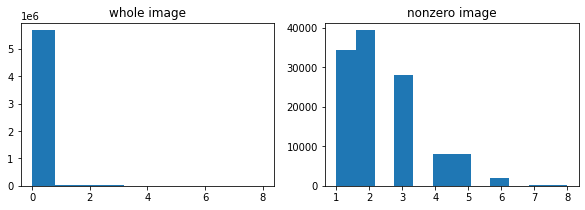

max duration 8 days


In [5]:
# get a flat list of all duration values 
duration_data = duration_img.ravel()
duration_data = duration_data[~np.isnan(duration_data)]

fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
ax0.hist(duration_data, bins=10)
ax1.hist(duration_data[duration_data>0], bins=12)  
ax0.set_title("whole image")
ax1.set_title("nonzero image")   
plt.show()

raw_max = int(max(duration_data))
print("max duration",raw_max,"days")

**HUOM!** Duration values in days can be longer than the flood duration implied in the filename (start / end dates)

**Decision:** use the max duration infetted by the image to control the image splitting operation, not the dates in the filenmaes

For this 8-day duration test image, split the duration image into individual images per day, by thresholding the duration. Store along with dates.

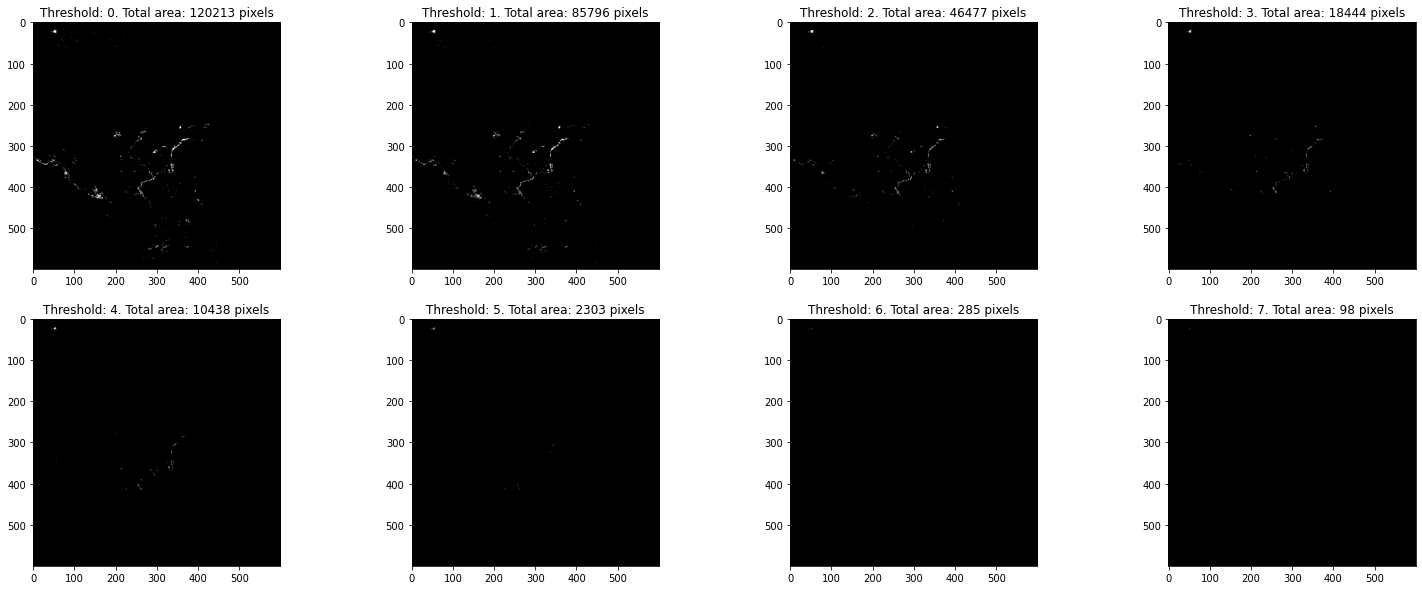

In [6]:
fig, ((ax0,ax1,ax2,ax3),(ax4,ax5,ax6,ax7)) = plt.subplots(2,4, figsize=(26,10))

thresh=0
for ax in [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]:
    im_t = duration_img.copy()
    
    # make binary image of values in (0,1)
    _,im_t = cv2.threshold(im_t,thresh,1,cv2.THRESH_BINARY)
    
    # visualize binary image 
    ax.imshow(255*cv2.resize(im_t, (600,600)),'gray')

    # note the area in pixel counts (sum of ones)
    data = im_t.ravel()
    data = data[~np.isnan(data)]
    pixel_area = int(sum(data))

    ax.set_title("Threshold: "+str(thresh)+". Total area: "+str(pixel_area)+" pixels")
    thresh += 1

plt.show()